## Deep Learning
   #### Computer Vision Winter Semester 2021/2022 by Clemens Spielvogel
    
Deep Learning algorithms have recently become very popular. Reasons for this are the increased availability of data, computational power and advances in algorithm architectures. Deep learning is usually performed via neural network algorithms. Neural networks consist of connected layers of neurons and can be shall (few layers) or deep (many layers). Goal of this notebook is to provide practical examples of how neural networks can be applied for image data.
   
Installations (Ubuntu)
   * If you do not have Anaconda installed: www.anaconda.com/products/individual 
   * If you do have a GPU: \$ conda install tensorflow-gpu (recommended)
   * If you do not have a GPU: \$ pip install tensorflow
   * \$ pip install keras
   
Resources:
   * Tensorflow tutorials: https://www.tensorflow.org/tutorials/
   * Tensorflow guide: https://www.tensorflow.org/guide/
   * Tensorflow documentation: https://www.tensorflow.org/versions/r1.14/api_docs/python/tf
   * Keras documentation: https://keras.io/

### Building a Neural Network using Keras and Tensorflow
Keras provides an easy-to-use interface for tensorflow but also comes with its own backend functionalities. There are many frameworks for deep learning, however Keras is one of the most used ones. Here, we will use Keras for building a classical neural network for a multiclass classification of images associated to three types of fruits.

In [6]:
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import LabelEncoder, StandardScaler

import os
import cv2
import scipy
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import display

print("Tensorflow version", tf.__version__)
print("Keras version", keras.__version__)

Tensorflow version 2.1.0
Keras version 2.2.4-tf


In [7]:
# Seeding random number generators to obtain reproducible results
seed_value = 1
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value) # Resets itself on every use!
tf.random.set_seed(seed_value) # tf.set_random_seed(seed_value) on older TF versions

In [8]:
def display_array(array):
    """Plotting numpy array"""
    plt.imshow(array.astype(np.uint8))
    plt.axis('off')
    plt.show()

The data we will be using are images of three kinds of fruits, apples, bananas and oranges. In total, the data set contains 232 images of apples, 218 of bananas and 206 of oranges. The dimensions are different for each image. To unify the image size and to decrease the run time, the images will be downsampled.

In [9]:
# Load image data and labels into separate containers
data_dir = "Data/fruits"

filenames = []
string_labels = []
images = []
label_folders = os.listdir(data_dir)
for folder in label_folders:
    folder_path = os.path.join(data_dir, folder)
    filenames = os.listdir(folder_path)
    filepaths = [os.path.join(folder_path, name) for name in filenames]    
    print(filepaths[0])
    images += [cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_RGB2BGR).astype(np.uint8) for file in filepaths]
    string_labels += [folder for _ in filenames]

images = np.array(images, dtype="object")
string_labels = np.array(string_labels)

print(len(images))
print(len(string_labels))
print(np.unique(string_labels))

Data/fruits\apple\Screen Shot 2018-06-08 at 4.59.36 PM.png
Data/fruits\banana\Screen Shot 2018-06-12 at 10.00.00 PM.png
Data/fruits\orange\Screen Shot 2018-06-12 at 11.50.14 PM.png
656
656
['apple' 'banana' 'orange']


apple: 232
banana: 218
orange: 206


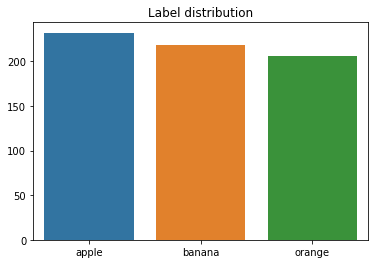

In [10]:
# Convert string labels to integers
encoder = LabelEncoder()
labels = encoder.fit_transform(string_labels)

# Get label frequency
labels = np.array(labels)
labels_unique, label_counts = np.unique(labels, return_counts=True)

# Display label frequency as text
string_labels_unique = encoder.inverse_transform(labels_unique)
[print("{}: {}".format(label, count)) for (label, count) in zip(string_labels_unique, label_counts)]

# Plot label frequency
sns.barplot(x=string_labels_unique, 
            y=label_counts, 
            ci=0)
plt.title("Label distribution")
plt.show()

In [11]:
# Bring images to same size
images_resized = [cv2.resize(img, (100, 100)) for img in images]

# Flatten images to 1D vector
features = np.array([img.flatten() for img in images_resized])

Original image examples:


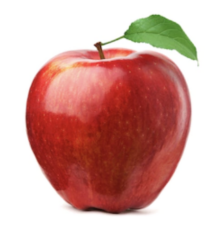

(476, 458, 3)


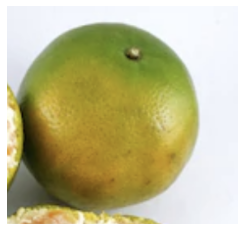

(264, 280, 3)

Neural network input image examples:


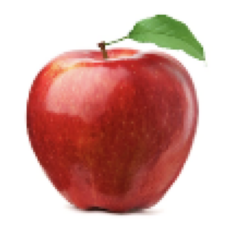

(100, 100, 3)


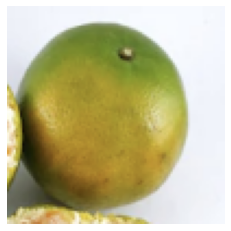

(100, 100, 3)


In [12]:
# Display original and resampled images
apple_file = os.listdir("Data/fruits/apple")[0]
orange_file = os.listdir("Data/fruits/orange")[-1]

apple = cv2.imread(os.path.join("Data/fruits/apple", apple_file))
apple = cv2.cvtColor(apple.astype("uint8"), cv2.COLOR_BGR2RGB) 
orange = cv2.imread(os.path.join("Data/fruits/orange", orange_file))
orange = cv2.cvtColor(orange.astype("uint8"), cv2.COLOR_BGR2RGB) 

print("Original image examples:")
display_array(apple)
print(apple.shape)
display_array(orange)
print(orange.shape)
print()

print("Neural network input image examples:")
display_array(images_resized[0])
print(images_resized[0].shape)
display_array(images_resized[-1])
print(images_resized[-1].shape)

In [13]:
np.random.seed(seed_value)

# Shuffle features and labels in same order
random_index_order = np.random.permutation(len(labels))
features = features[random_index_order]
labels = labels[random_index_order]

# Determine split sizes
train_ratio = 0.7
test_ratio = 0.3
train_size = math.floor(train_ratio * len(labels))
test_size = math.floor(test_ratio * len(labels))

# Create splitted sets
X_train, y_train = np.array(features[:train_size]), np.array(labels[:train_size])
X_test, y_test = np.array(features[train_size:]), np.array(labels[train_size:])

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# Create keras model architecture
model = keras.Sequential()
model.add(keras.layers.Dense(64, input_dim=30000, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(3, activation="softmax"))

In [15]:
# Create model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

In [16]:
# Configure stopping criterion via early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)

In [17]:
# Train model
history = model.fit(X_train, 
                    y_train,
                    validation_split=0.2,
                    epochs=100,
                    callbacks=[callback],
                    verbose=True)

Train on 367 samples, validate on 92 samples
Epoch 1/100
367/367 [==============================] - 1s 2ms/sample - loss: 2.1376 - sparse_categorical_accuracy: 0.8256 - val_loss: 3.2820 - val_sparse_categorical_accuracy: 0.8370
Epoch 2/100
367/367 [==============================] - 0s 561us/sample - loss: 1.4880 - sparse_categorical_accuracy: 0.9346 - val_loss: 3.3494 - val_sparse_categorical_accuracy: 0.8587
Epoch 3/100
367/367 [==============================] - 0s 612us/sample - loss: 0.8934 - sparse_categorical_accuracy: 0.9373 - val_loss: 6.7937 - val_sparse_categorical_accuracy: 0.8696
Epoch 4/100
367/367 [==============================] - 0s 563us/sample - loss: 0.8174 - sparse_categorical_accuracy: 0.9728 - val_loss: 3.2952 - val_sparse_categorical_accuracy: 0.8804
Epoch 5/100
367/367 [==============================] - 0s 546us/sample - loss: 0.3137 - sparse_categorical_accuracy: 0.9728 - val_loss: 2.1853 - val_sparse_categorical_accuracy: 0.8913
Epoch 6/100
367/367 [===========

367/367 [==============================] - 0s 587us/sample - loss: 4.3101e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.6439 - val_sparse_categorical_accuracy: 0.8370
Epoch 45/100
367/367 [==============================] - 0s 567us/sample - loss: 4.1542e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.6428 - val_sparse_categorical_accuracy: 0.8370
Epoch 46/100
367/367 [==============================] - 0s 564us/sample - loss: 4.0529e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.6416 - val_sparse_categorical_accuracy: 0.8370
Epoch 47/100
367/367 [==============================] - 0s 548us/sample - loss: 3.9405e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.6403 - val_sparse_categorical_accuracy: 0.8370
Epoch 48/100
367/367 [==============================] - 0s 590us/sample - loss: 3.8294e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.6392 - val_sparse_categorical_accuracy: 0.8370
Epoch 49/100
367/367 [==============================] - 0s 687u

In [18]:
print(history.history)

{'loss': [2.1375927509339046, 1.4879985948050143, 0.893383513637474, 0.8173645766447514, 0.31371689198189034, 0.026938367911583484, 0.0002216250640545546, 0.00024684289584727927, 8.456995726987461e-05, 5.0472440374017465e-05, 3.600348628806659e-05, 2.9486719741460955e-05, 2.4625447914771312e-05, 2.069763775373285e-05, 1.852427859234637e-05, 1.702251088429526e-05, 1.535768639220312e-05, 1.3937416406902194e-05, 1.3090654731178941e-05, 1.2144279924845677e-05, 1.1404644716819041e-05, 1.0635458247832488e-05, 1.0117547112533067e-05, 9.47754381317336e-06, 8.984293166253715e-06, 8.563442187400414e-06, 8.075038482022202e-06, 7.73763666778761e-06, 7.37134013005389e-06, 7.025484219337391e-06, 6.71925057912574e-06, 6.395802911629041e-06, 6.1333968226961596e-06, 5.9083366597250474e-06, 5.690090494795496e-06, 5.47541510259824e-06, 5.287699315870022e-06, 5.153242018819553e-06, 4.948310730439792e-06, 4.826844105629333e-06, 4.665758997027629e-06, 4.54201716267899e-06, 4.4143794500461305e-06, 4.31012381

In [19]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)

# Display output
print("ACC:", round(test_acc, 2))

197/197 [==============================] - 0s 305us/sample - loss: 1.4951 - sparse_categorical_accuracy: 0.9086
ACC: 0.91


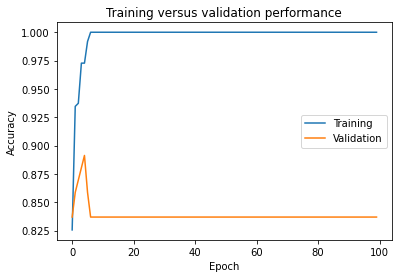

In [20]:
# Plot Performance
num_epochs = len(history.history["sparse_categorical_accuracy"])
sns.lineplot(x=np.arange(num_epochs), y=history.history["sparse_categorical_accuracy"])
sns.lineplot(x=np.arange(num_epochs), y=history.history["val_sparse_categorical_accuracy"])
plt.legend(labels=["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training versus validation performance")
plt.show()

### Same network with augmented images

In [21]:
def augment_data(X_train, y_train, size=0):
    """ONLY FOR TRAINING DATA. Generate synthetic images by simple transformations. 
    Size is the number of samples to be returned.  If size is set to zero, the same number 
    as input images is returned."""
    
    # Convert images to 2D
    images = [image.reshape(100, 100, 3) for image in X_train]
    
    # Set number of images to augment to the same number as input images if size is zero
    if size == 0:
        size = len(images)
    
    # Create augmented images equal to size
    augmented_images = []
    new_labels = []
    for i in np.arange(size):
        
        # Select random images
        random_index = np.random.choice(np.arange(0, len(images)))
        img = images[random_index]
        
        # Rotate image with random parameters
        rows,cols = img.shape[:2]
        rot_matrix = cv2.getRotationMatrix2D(center=(cols/2, rows/2), 
                                             angle=np.random.randint(0, 35), 
                                             scale=1)
        img = cv2.warpAffine(img, rot_matrix, (cols,rows))
        
        # Add augmented image and corresponding labels to result containers
        augmented_images.append(img.flatten())
        new_labels.append(labels[random_index])
        
    return np.array(augmented_images), np.array(new_labels)

In [22]:
# Create augmented training data set
X_train_augmented, y_train_augmented = augment_data(X_train, y_train, 5000)

In [23]:
def transform_to_img_range(array1d):
    """Convert all values in a 1D array to be between 0 and 255"""
    new_array = []
    for old_val in array1d:
        old_range = np.max(array1d) - np.min(array1d)
        if old_range == 0:
            new_val = 0
        else:
            new_val = ((old_val - np.min(array1d)) * 255 / old_range)
            
        new_array.append(new_val)
    
    return np.round(np.array(new_array)).astype(np.int16)

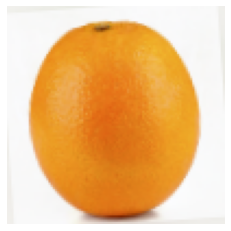

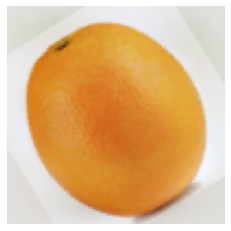

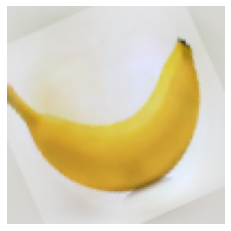

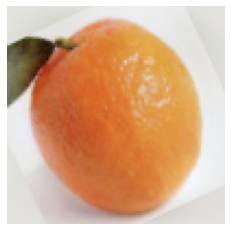

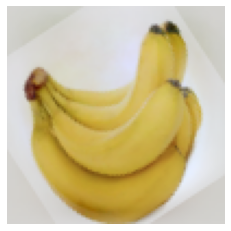

In [32]:
# Display example augmented images
for i in range(0, 5):
    # Revert standardization and 
    nonstd_img = transform_to_img_range(scaler.inverse_transform(X_train_augmented[i].reshape(1, -1)))
    reshaped_img = nonstd_img.reshape(100, 100, 3)
    recast_img = reshaped_img.astype(np.uint8)

    display_array(recast_img)

In [34]:
# Create keras model architecture
model = keras.Sequential()
model.add(keras.layers.Dense(64, input_dim=30000, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(3, activation="softmax"))

# Create model
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["sparse_categorical_accuracy"])

# Configure stopping criterion via early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)

# Train model
history_augmented = model.fit(X_train_augmented, 
                              y_train_augmented,
                              validation_split=0.2,
                              epochs=100,
                              callbacks=[callback],
                              verbose=True)

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 3s 676us/sample - loss: 0.4936 - sparse_categorical_accuracy: 0.9582 - val_loss: 0.1033 - val_sparse_categorical_accuracy: 0.9780
Epoch 2/100
4000/4000 [==============================] - 2s 568us/sample - loss: 0.0703 - sparse_categorical_accuracy: 0.9925 - val_loss: 0.0848 - val_sparse_categorical_accuracy: 0.9950
Epoch 3/100
4000/4000 [==============================] - 2s 613us/sample - loss: 0.0876 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.1387 - val_sparse_categorical_accuracy: 0.9820
Epoch 4/100
1088/4000 [=======>......................] - ETA: 1s - loss: 0.1598 - sparse_categorical_accuracy: 0.9853

KeyboardInterrupt: 

197/197 [==============================] - 0s 254us/sample - loss: 2.1728 - sparse_categorical_accuracy: 0.9137
ACC: 0.91


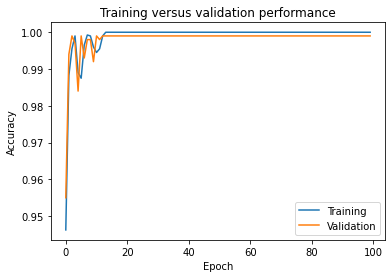

In [35]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)

# Display output
print("ACC:", round(test_acc, 2))

# Plot performance
num_epochs = len(history_augmented.history["sparse_categorical_accuracy"])
sns.lineplot(x=np.arange(num_epochs), y=history_augmented.history["sparse_categorical_accuracy"])
sns.lineplot(x=np.arange(num_epochs), y=history_augmented.history["val_sparse_categorical_accuracy"])
plt.legend(labels=["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training versus validation performance")
plt.show()

#### Investigating the loss of a model
Looking into the loss of a given model provides you with a more granular representation on the performance of a model compared to conventional performance metrics such as accuracy.
Note for the following plots how clear the difference in training versus validation performance is when compared with the performance plots above. This might help you to more easily diagnose issues with your model such as the occurence of overfitting.

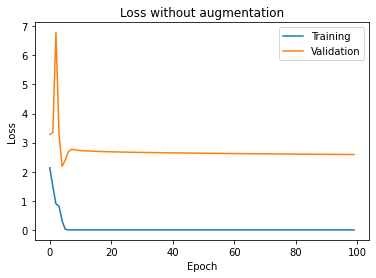

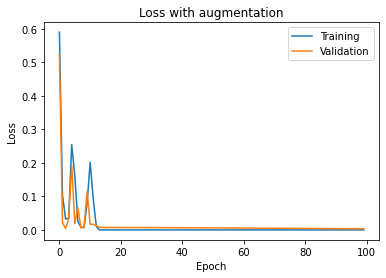

In [36]:
# Plot loss for model with and without augmentation
num_epochs = len(history.history["loss"])
sns.lineplot(x=np.arange(num_epochs), y=history.history["loss"])
sns.lineplot(x=np.arange(num_epochs), y=history.history["val_loss"])
plt.legend(labels=["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss without augmentation")
plt.show()

num_epochs = len(history_augmented.history["loss"])
sns.lineplot(x=np.arange(num_epochs), y=history_augmented.history["loss"])
sns.lineplot(x=np.arange(num_epochs), y=history_augmented.history["val_loss"])
plt.legend(labels=["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss with augmentation")
plt.show()

#### Assessment of incorrectly classified instances
Having a look into the samples which your model was not able to predict correctly is another approach to diagnose issues and improve your model in general.

True class: apple
Predicted class: orange


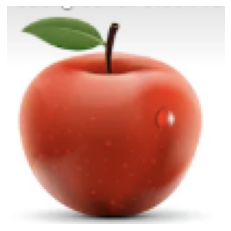

True class: apple
Predicted class: orange


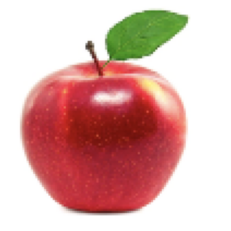

True class: apple
Predicted class: orange


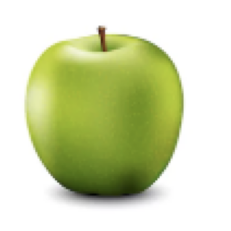

True class: banana
Predicted class: apple


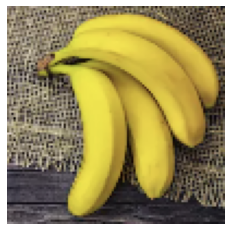

True class: banana
Predicted class: orange


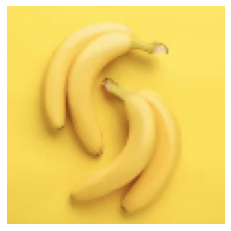

In [38]:
num_show = 5 # Maximum number of displayed instances

# Iterate through test instances
for X_instance, y_instance in zip(X_test, y_test):
    
    # Predict class for each instance
    y_pred_one_hot = model.predict(np.array([X_instance]))
    
    # Retrieve integer from one-hot encoded class
    y_pred = np.argmax(y_pred_one_hot)
    
    # Check whether class is incorrect
    if y_pred != y_instance and num_show > 0:
        # Display true and predicted class
        print("True class:", encoder.inverse_transform([y_instance])[0])
        print("Predicted class:", encoder.inverse_transform([y_pred])[0])
        
        # Backtransform feature vector to image
        reconstructed_img = scaler.inverse_transform(X_instance.reshape(1, -1))
        reshaped_img = reconstructed_img.reshape((100, 100, 3))

        # Display incorrectly predicted image
        display_array(reshaped_img)
        
        # Update maximum number of images to show
        num_show -=1

In [39]:
# Display model details
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                1920064   
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 195       
Total params: 1,924,419
Trainable params: 1,924,419
Non-trainable params: 0
_________________________________________________________________
None
